In [3]:
figdir = "./showdown/output/images/"

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import re
import jax
import optax
import distrax
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import flax.linen as nn
import jax.numpy as jnp

from time import time
from copy import deepcopy
from functools import partial
from itertools import product
from tqdm.notebook import tqdm
from matplotlib.animation import FuncAnimation
from typing import Callable, Tuple, Any
from jax.flatten_util import ravel_pytree
from flax.training.train_state import TrainState

import rebayes
from rebayes import base
from rebayes.base import Rebayes
from rebayes.extended_kalman_filter import ekf
from rebayes.low_rank_filter import lofi, lrvga
from rebayes.sgd_filter import sgd
from rebayes.sgd_filter import replay_sgd as rsgd
from rebayes.utils import nonstat_1d_data as datagen

In [4]:
from rebayes.utils.sampling import sample_dlr

In [5]:
plt.rcParams["font.size"] = 14
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["legend.fontsize"] = 14
# plt.rcParams["lines.linewidth"] = 2

In [6]:
%config InlineBackend.figure_format = "retina"

# Data

In [7]:
key = jax.random.PRNGKey(314)
n_dist = 6
n_train = 100
data_flat, data_tasks = datagen.sample_1d_regression_sequence(key, n_dist, n_train=n_train)
jax.tree_map(jnp.shape, data_flat)

{'test': {'X': (600, 1), 'id_seq': (600,), 'y': (600, 1)},
 'train': {'X': (600, 1), 'id_seq': (600,), 'y': (600, 1)}}

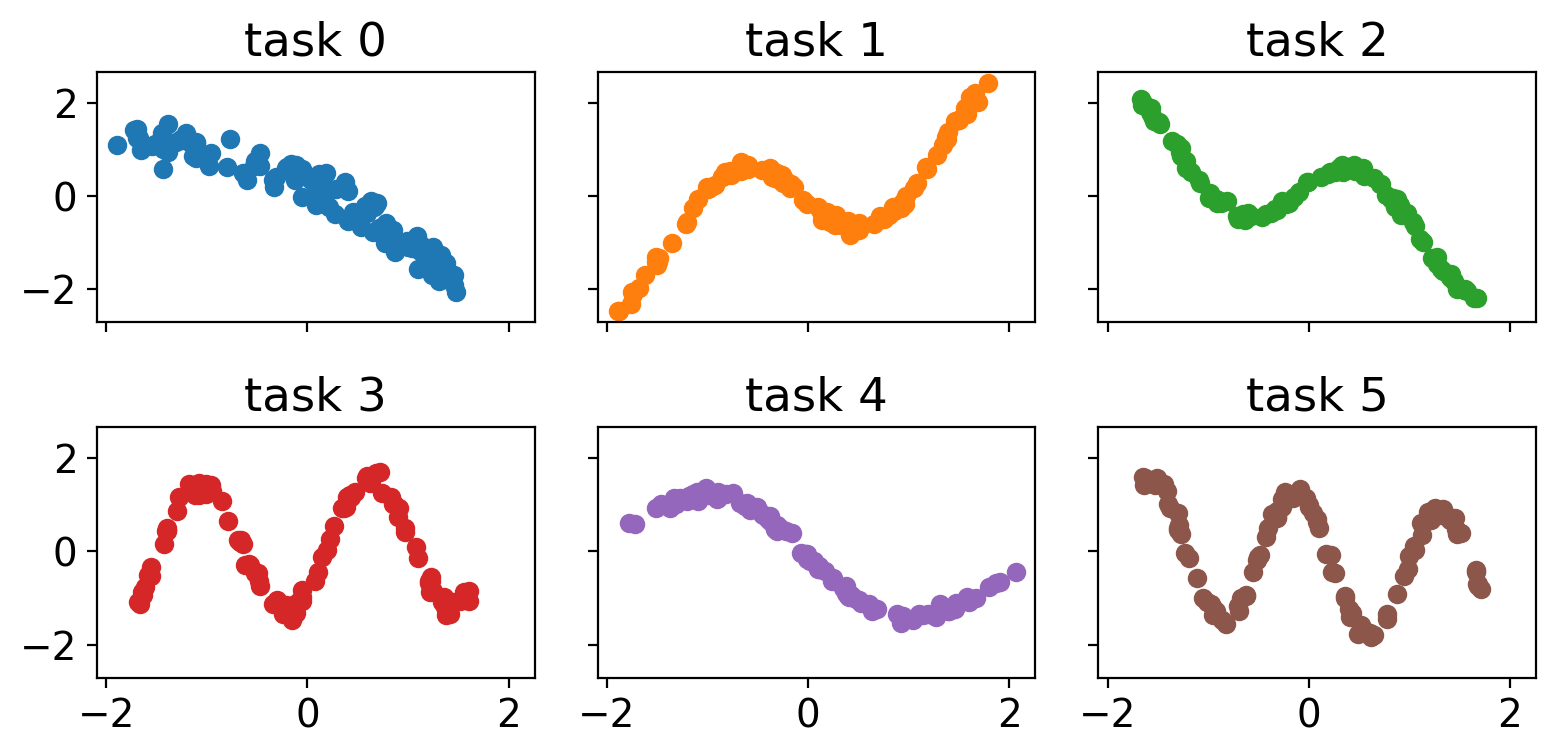

In [8]:
fig, axs = plt.subplots(2, 3, figsize=(8, 4), sharex=True, sharey=True)

colors = plt.cm.tab10(np.arange(n_dist))
for n, ax in enumerate(axs.ravel()):
    data_slice = datagen.slice_tasks(data_flat, n)
    c=colors[n]
    ax.scatter(data_slice["train"]["X"], data_slice["train"]["y"], color=c)
    ax.set_title(f"task {n}")
plt.tight_layout()

## Modeling

In [9]:
class MLP(nn.Module):
    n_out: int
    n_hidden: int
    activation: Callable = nn.tanh
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.n_hidden)(x)
        x = self.activation(x)
        x = nn.Dense(self.n_out)(x)
        return x
    
def make_bnn_flax(nhidden=50):
    key = jax.random.PRNGKey(314)
    dim_out = 1
    dim_in = 1 
    model = MLP(dim_out, nhidden)
    params = model.init(key, jnp.ones((1, dim_in)))
    flat_params, recfn = ravel_pytree(params)
    n_params = len(flat_params)
    return model, params, flat_params, recfn

In [10]:
model, dnn_params, flat_params, recfn = make_bnn_flax()

In [11]:
def apply_fn_flat(flat_params, x):
    return model.apply(recfn(flat_params), x)

def apply_fn_unflat(params, x):
    return model.apply(params, x)

ssm_params = base.RebayesParams(
        initial_mean=flat_params,
        initial_covariance=0.06,
        dynamics_weights=1,
        dynamics_covariance=1e-7,#1e-6,
        emission_mean_function=apply_fn_flat,
        emission_cov_function = lambda w,x: 0.02,
        adaptive_emission_cov=False,
        dynamics_covariance_inflation_factor=0.001,
    )


@partial(jax.jit, static_argnames=("apply_fn",))
def lossfn_rmse_fifo(params, counter, X, y, apply_fn):
    yhat = apply_fn(params, X).ravel()
    y = y.ravel()
    err = jnp.power(y - yhat, 2)
    loss = (err * counter).sum() / counter.sum()
    return loss


# For L-RVGA
def fwd_link_main(mean, bel, x, model, reconstruct_fn):
    params = reconstruct_fn(mean)
    means = model.apply(params, x).ravel()
    std = bel.sigma
    return means, std ** 2


def log_prob_main(mean, bel, x, y, fwd_link):
    yhat, var = fwd_link(mean, bel, x)
    std = jnp.sqrt(var)
    
    logp = distrax.Normal(yhat, std).log_prob(y).sum()
    return logp

In [12]:
X_train_seq = data_flat["train"]["X"]
Y_train_seq = data_flat["train"]["y"]
train_id_seq = data_flat["train"]["id_seq"]

X_test_seq = data_flat["test"]["X"]
Y_test_seq = data_flat["test"]["y"]
test_id_set = data_flat["test"]["id_seq"]


X_test_tasks = data_tasks["train"]["X"]
Y_test_tasks = data_tasks["train"]["y"]
X_train_tasks = data_tasks["train"]["X"]
Y_train_tasks = data_tasks["train"]["y"]

## Methods

In [13]:
key = jax.random.PRNGKey(314)

In [28]:
n_samples = 55
xeval = jnp.linspace(-2.0, 2.0, num=100)[:, None]

def callback(bel, pred_obs, t, Xt, Yt, bel_pred, apply_fn, agent, **kwargs):    
    # eval on all tasks test set
    yhat = apply_fn(bel.mean, X_test_seq).squeeze()
    ytrue = Y_test_seq.squeeze()
    rmse_test_all_tasks = jnp.mean(jnp.square(yhat - ytrue)) 

    # eval on current task 
    task = train_id_seq[t]
    yhat = apply_fn(bel.mean, X_test_tasks[task]).squeeze()

    ytrue = Y_test_tasks[task].squeeze()
    rmse_test_current_task = jnp.sqrt(jnp.mean(jnp.square(yhat - ytrue)))
    mae_test_current_task = jnp.mean(jnp.abs(yhat - ytrue))
    
    key_step = jax.random.fold_in(key, t)
    yhat_samples = agent.pred_obs_mc(key_step, bel, xeval, shape=(n_samples,))


    out = {'rmse_test_all_tasks': rmse_test_all_tasks,
           'rmse_test_current_task': rmse_test_current_task,
           'mae_test_current_task': mae_test_current_task,
           'pred_test_current_task': yhat,
           "yhat_samples": yhat_samples,
           }
    return out

In [58]:
method_list = []
estimator_dict, callback_dict = {}, {}

mem = 10
method = "lofi"
lofi_params = lofi.LoFiParams(memory_size=mem, steady_state=False)
# my_ssm_params = deepcopy(ssm_params)
# my_ssm_params = my_ssm_params.replace(dynamics_covariance_inflation_factor = alpha, dynamics_covariance = q)
estimator = lofi.RebayesLoFiDiagonal(ssm_params, lofi_params)

estimator_dict[method] = estimator
apply_fn = estimator.params.emission_mean_function
callback_dict[method] = partial(callback,
                                apply_fn=apply_fn,
                                agent=estimator,
                               )


lr, buffer = 0.01, 1
method = "sgd-o"
estimator = rsgd.FifoSGD(lossfn_rmse_fifo, 
                    apply_fn=apply_fn_unflat,
                    init_params = dnn_params,
                    tx = optax.adam(learning_rate=lr),
                    buffer_size = buffer,
                    dim_features = X_train_seq.shape[1],
                    dim_output = 1,
                    n_inner=1)

estimator_dict[method] = estimator
callback_dict[method] = partial(callback,
                                apply_fn=apply_fn_unflat,
                                agent=estimator
                               )


lr, buffer = 0.05, 10
method = "sgd-rb"
estimator = rsgd.FifoSGD(lossfn_rmse_fifo, 
                    apply_fn=apply_fn_unflat,
                    init_params = dnn_params,
                    tx = optax.adam(learning_rate=lr),
                    buffer_size = buffer,
                    dim_features = X_train_seq.shape[1],
                    dim_output = 1,
                    n_inner=1)

estimator_dict[method] = estimator
callback_dict[method] = partial(callback,
                                apply_fn=apply_fn_unflat,
                                agent=estimator,
                               )



method = "fcekf"
estimator = ekf.RebayesEKF(ssm_params, method=method)
estimator_dict[method] = estimator
callback_dict[method] = partial(callback,
                                apply_fn=apply_fn_flat,
                                agent=estimator,
                               )


method = "fdekf"
estimator = ekf.RebayesEKF(ssm_params, method=method)
estimator_dict[method] = estimator
callback_dict[method] = partial(callback,
                                apply_fn=apply_fn_flat,
                                agent=estimator,
                               )

method = "lrvga"
dim_rank = 10
std = 1.0
eps = 1e-6
sigma2 = 1.5

alpha = 0.997
n_samples = 50
n_outer = 5
n_inner = 6

bel_init_lrvga, reconstruct_fn = lrvga.init_lrvga(key, model, X_train_seq, dim_rank, std, eps, sigma2)

fwd_link = partial(fwd_link_main, model=model, reconstruct_fn=reconstruct_fn)
log_prob = partial(log_prob_main, fwd_link=fwd_link)

estimator = lrvga.LRVGA(fwd_link, log_prob, n_samples=n_samples, n_outer=n_outer, n_inner=n_inner, alpha=alpha)

estimator_dict[method] = estimator
callback_dict[method] = partial(callback,
                                apply_fn=apply_fn_flat,
                                agent=estimator,
                               )

In [ ]:
%%time
ellapsed_dict = {}
output_dict = {}

for estimator in estimator_dict:
    print(estimator, end="\r")
    bel = None if estimator != "lrvga" else bel_init_lrvga
    t_init = time()
    callback = callback_dict[estimator]
    bel, outputs = estimator_dict[estimator].scan(X_train_seq, Y_train_seq, callback=callback, bel=bel, progress_bar=True)
    bel = jax.block_until_ready(bel)
    t_end = time()
    
    ellapsed = t_end- t_init
    ellapsed_dict[estimator] = ellapsed
    output_dict[estimator] = outputs

In [60]:
def parse_name(method):
    parts = method.split()
    name = parts[0]
    numbers = re.findall(r"[-+]?(?:\d*\.*\d+)", method)
    if False: #name=='lofi':
        mem, q, alpha = numbers[0], float(numbers[1]), float(numbers[2])
        if q > 0:
            style = ':'
        else:
            style = '-.'
        if alpha > 0:
            marker = 'o'
        else:
            marker = 'x'
    elif name == 'lofi':
        style = ':'
        marker = 'o'
    elif name == 'sgd':
        style = '--'
        marker = 'x'
    elif "lrvga" in name:
        style = "dashdot"
        marker = "v"
    else:
        style = '-'
        marker = '*'
    return style, marker

def make_plot_dict(method_list):
    nmethods = len(method_list)
    colors = plt.cm.tab10(np.arange(nmethods)+1)
    color_dict, style_dict, marker_dict = {}, {}, {}
    for i, method in enumerate(method_list):
        style, marker = parse_name(method)
        style_dict[method] = style
        marker_dict[method] = marker
        color_dict[method] = colors[i,:]
    return color_dict, style_dict, marker_dict

In [61]:
def plot_pred(Xtr, ytr, Xte, yte, yhat, ttl, ax=None):
    if ax is None:
        fig, ax = plt.subplot()
    
    ixs_tr = np.argsort(Xtr, 0).ravel()
    ixs_te = np.argsort(Xte, 0).ravel()
    
    ax.plot(Xtr[ixs_tr], ytr[ixs_tr], color="black", label='train')
    ax.scatter(Xte[ixs_te], yte[ixs_te], color="tab:red", label='test', alpha=0.8)
    ax.scatter(Xte[ixs_te], yhat[ixs_te], color="tab:blue", label='pred', alpha=0.8)
    ax.set_xticklabels([])

def plot_pred_task(task, outputs, ax, name='', offset=0):
    times = jnp.where(train_id_seq == task)
    last_time = times[0][-1]
    yhat = outputs['pred_test_current_task'][last_time,:]
    rmse = outputs['rmse_test_current_task'][last_time]
    mae = outputs['mae_test_current_task'][last_time]
    ttl = '{:s}, mae={:0.3f}'.format(name,  mae)
    plot_pred(X_train_tasks[task], Y_train_tasks[task], X_test_tasks[task], Y_test_tasks[task], yhat, ttl, ax)

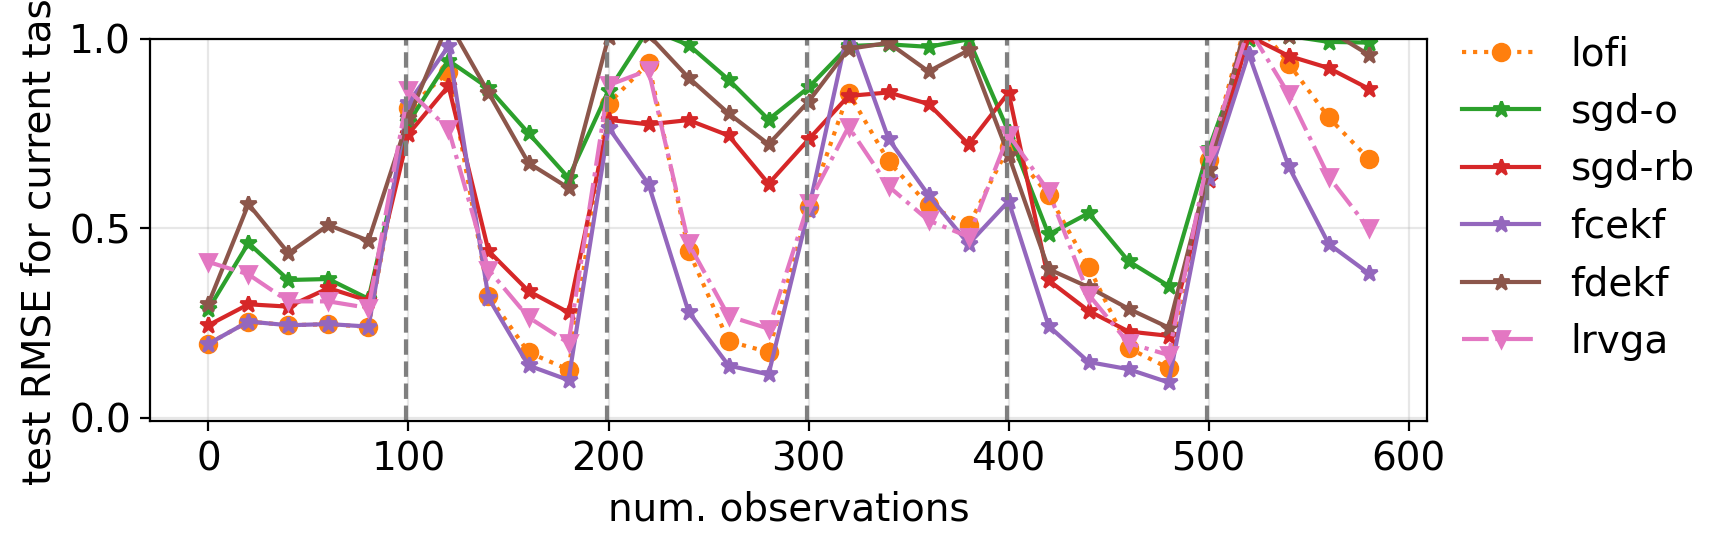

In [62]:
ntasks, ntrain_per_task, _ = X_train_tasks.shape
changepoints = np.arange(ntrain_per_task, (ntasks)*ntrain_per_task, step=ntrain_per_task)-1
color_dict, style_dict, marker_dict = make_plot_dict(list(estimator_dict.keys()))

plt.figure(figsize=(9, 3))
for method in estimator_dict:
    kernel_size = 20
    
    kernel = jnp.ones(kernel_size) / kernel_size
    rmse_trace = output_dict[method]['rmse_test_current_task']
    rmse_smoothed = jnp.convolve(rmse_trace, kernel, mode='same')

    ndata = len(rmse_smoothed)
    ndx = np.arange(0, ndata, step=20) # thin the data so we can see the markers
    
    color = color_dict[method]
    linestyle = style_dict[method]
    marker = marker_dict[method]
    plt.plot(ndx, rmse_smoothed[ndx], label=method, color=color, linestyle=linestyle, marker=marker)
    #plt.plot(ndx, rmse_smoothed[ndx], label=ttl, color=color_list[i], linestyle=style_list[i], marker=marker_list[i])
#plt.ylim([0, 1.5])

for c in changepoints:
    plt.axvline(x=c, color="tab:gray", linestyle="--")
# plt.legend(bbox_to_anchor=(0.7, -0.2), frameon=False)
plt.legend(bbox_to_anchor=(1, 1.1), frameon=False)
plt.ylabel('test RMSE for current task')
plt.xlabel('num. observations')
plt.grid(alpha=0.3)
plt.ylim(-0.01, 1.0)
plt.tight_layout()

# plt.savefig(figdir + '/regression_plot_1d_lofi.pdf')
# plt.savefig(figdir + '/regression_plot_1d_lofi.png')

CPU times: user 5.23 s, sys: 1.06 s, total: 6.28 s
Wall time: 3.46 s


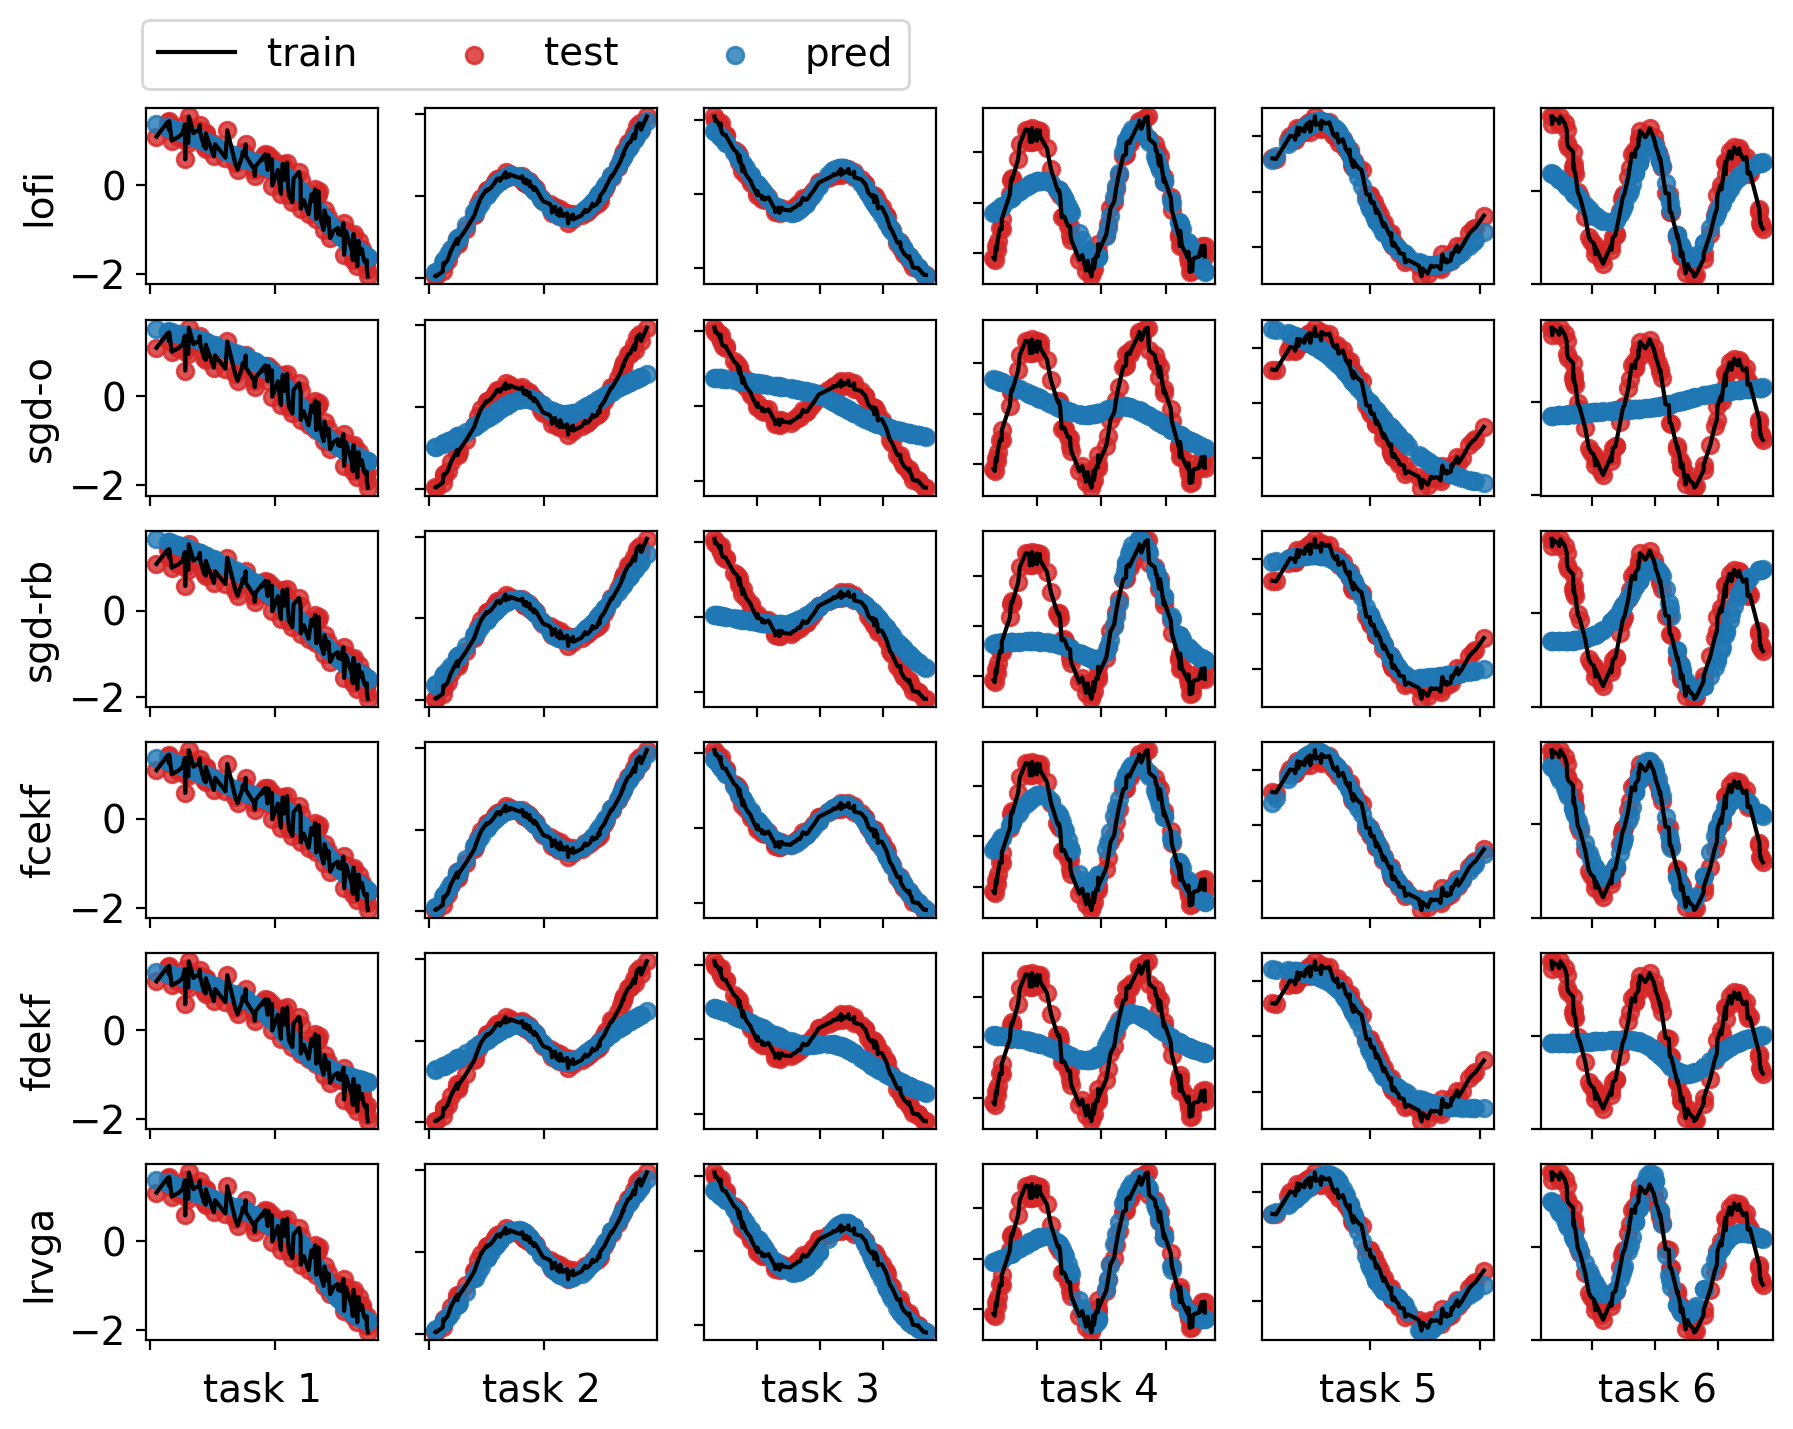

In [63]:
%%time
fig, axs_grid = plt.subplots(6, 6, figsize=(10.5,  8))

for axs, method in zip(axs_grid, output_dict):
    outputs = output_dict[method]
        
    for task, ax in enumerate(axs):
        plot_pred_task(task, outputs, ax, method)
        if task == 0:
            ax.set_ylabel(method)
        else:
            ax.set_yticklabels([])

for t, ax in enumerate(axs):
    ax.set_xlabel(f"task {t+1}")
axs_grid[0, 0].legend(ncol=3, bbox_to_anchor=(-0.1, 1.0), loc="lower left")
# plt.tight_layout()
# plt.savefig(figdir + '/regression_plot_1d_pred.png', dpi=200)

# Animation

In [67]:
def reshape_task(x):
    _, *shape = x.shape
    new_shape = (n_dist, -1, *shape)
    return x.reshape(new_shape)

xtest_ravel = jnp.linspace(-2.0, 2.0, num=100)[:, None]

@partial(jax.vmap, in_axes=(0, None, None, None))
@partial(jax.vmap, in_axes=(None, 0, None, None))
def xmap_yhat(task, obs, bel_reshape, apply_fn):
    bel = jax.tree_map(lambda x: x[task, obs, ...], bel_reshape)
    task = train_id_seq[t]
    yhat = apply_fn(bel.mean, xtest_ravel).squeeze()
    
    return yhat

## Comparison posterior mean

In [71]:
from rebayes.utils.utils import tree_to_cpu, get_subtree

In [116]:
yhat_samples = tree_to_cpu(get_subtree(output_dict, "yhat_samples"))
yhat_samples = jax.tree_map(jnp.squeeze, yhat_samples)

def rearrage_samples(x):
    return einops.rearrange(x, "(task obs) sample eval -> task obs sample eval", task=6)

yhat_samples_xmap = jax.tree_map(rearrage_samples, yhat_samples)
jax.tree_map(np.shape, yhat_samples_xmap)

{'fcekf': (6, 100, 50, 100),
 'fdekf': (6, 100, 50, 100),
 'lofi': (6, 100, 50, 100),
 'lrvga': (6, 100, 50, 100),
 'sgd-o': (6, 100, 50, 100),
 'sgd-rb': (6, 100, 50, 100)}

In [118]:
Y_test_tasks = np.array(Y_test_tasks)
X_test_tasks = np.array(X_test_tasks)

In [119]:
ymin, ymax = Y_train_tasks.min(), Y_train_tasks.max()

CPU times: user 1min 59s, sys: 8.47 s, total: 2min 7s
Wall time: 1min 46s


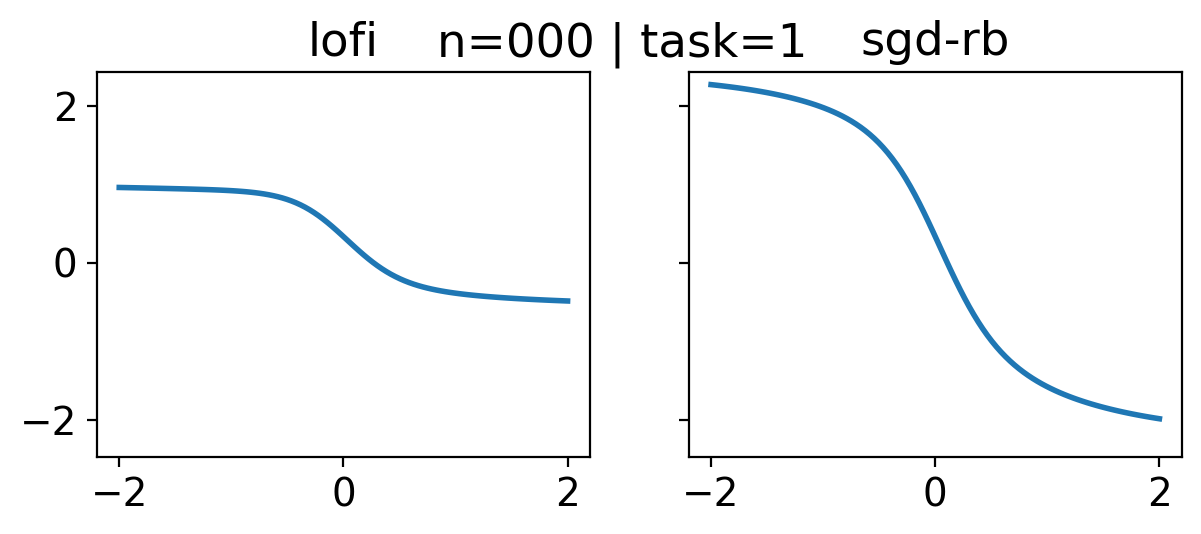

In [126]:
%%time
fig, axs = plt.subplots(1, 2, figsize=(7, 2.5), sharex=True, sharey=True)

labels = ["lofi", "sgd-rb"]

def update(ix):
    num_obs = ix % n_train
    task = ix // n_train
    
    for ax, label in zip(axs, labels):
        ax.cla()
        
        yhat_xmap = yhat_samples_xmap[label]
        yhat = yhat_xmap[task, num_obs, ...].mean(axis=0)

        # nmin = jnp.clip(num_obs - 20, 0)
        nmin = 0

        xtest = X_test_tasks[task][nmin:num_obs]
        ytrue = Y_test_tasks[task].ravel()[nmin:num_obs]

        ax.plot(xtest_ravel, yhat, c="tab:blue", linewidth=2)
        ax.scatter(xtest, ytrue, facecolors="none", edgecolors="tab:gray")
        if len(xtest) > 0:
            ax.scatter(xtest[-1], ytrue[-1], c="tab:red")
        
        ax.set_ylim(ymin, ymax)
        ax.set_title(label)
    plt.suptitle(f"n={num_obs:03} | task={task+1}")
    return axs


frames = np.arange(n_dist * n_train)
ani = FuncAnimation(fig, update, frames=frames)

ani.save("./figures/learned_hist-v2.mp4", dpi=100, bitrate=-1, fps=10)

## Comparison posterior predictive

CPU times: user 717 ms, sys: 250 ms, total: 967 ms
Wall time: 506 ms


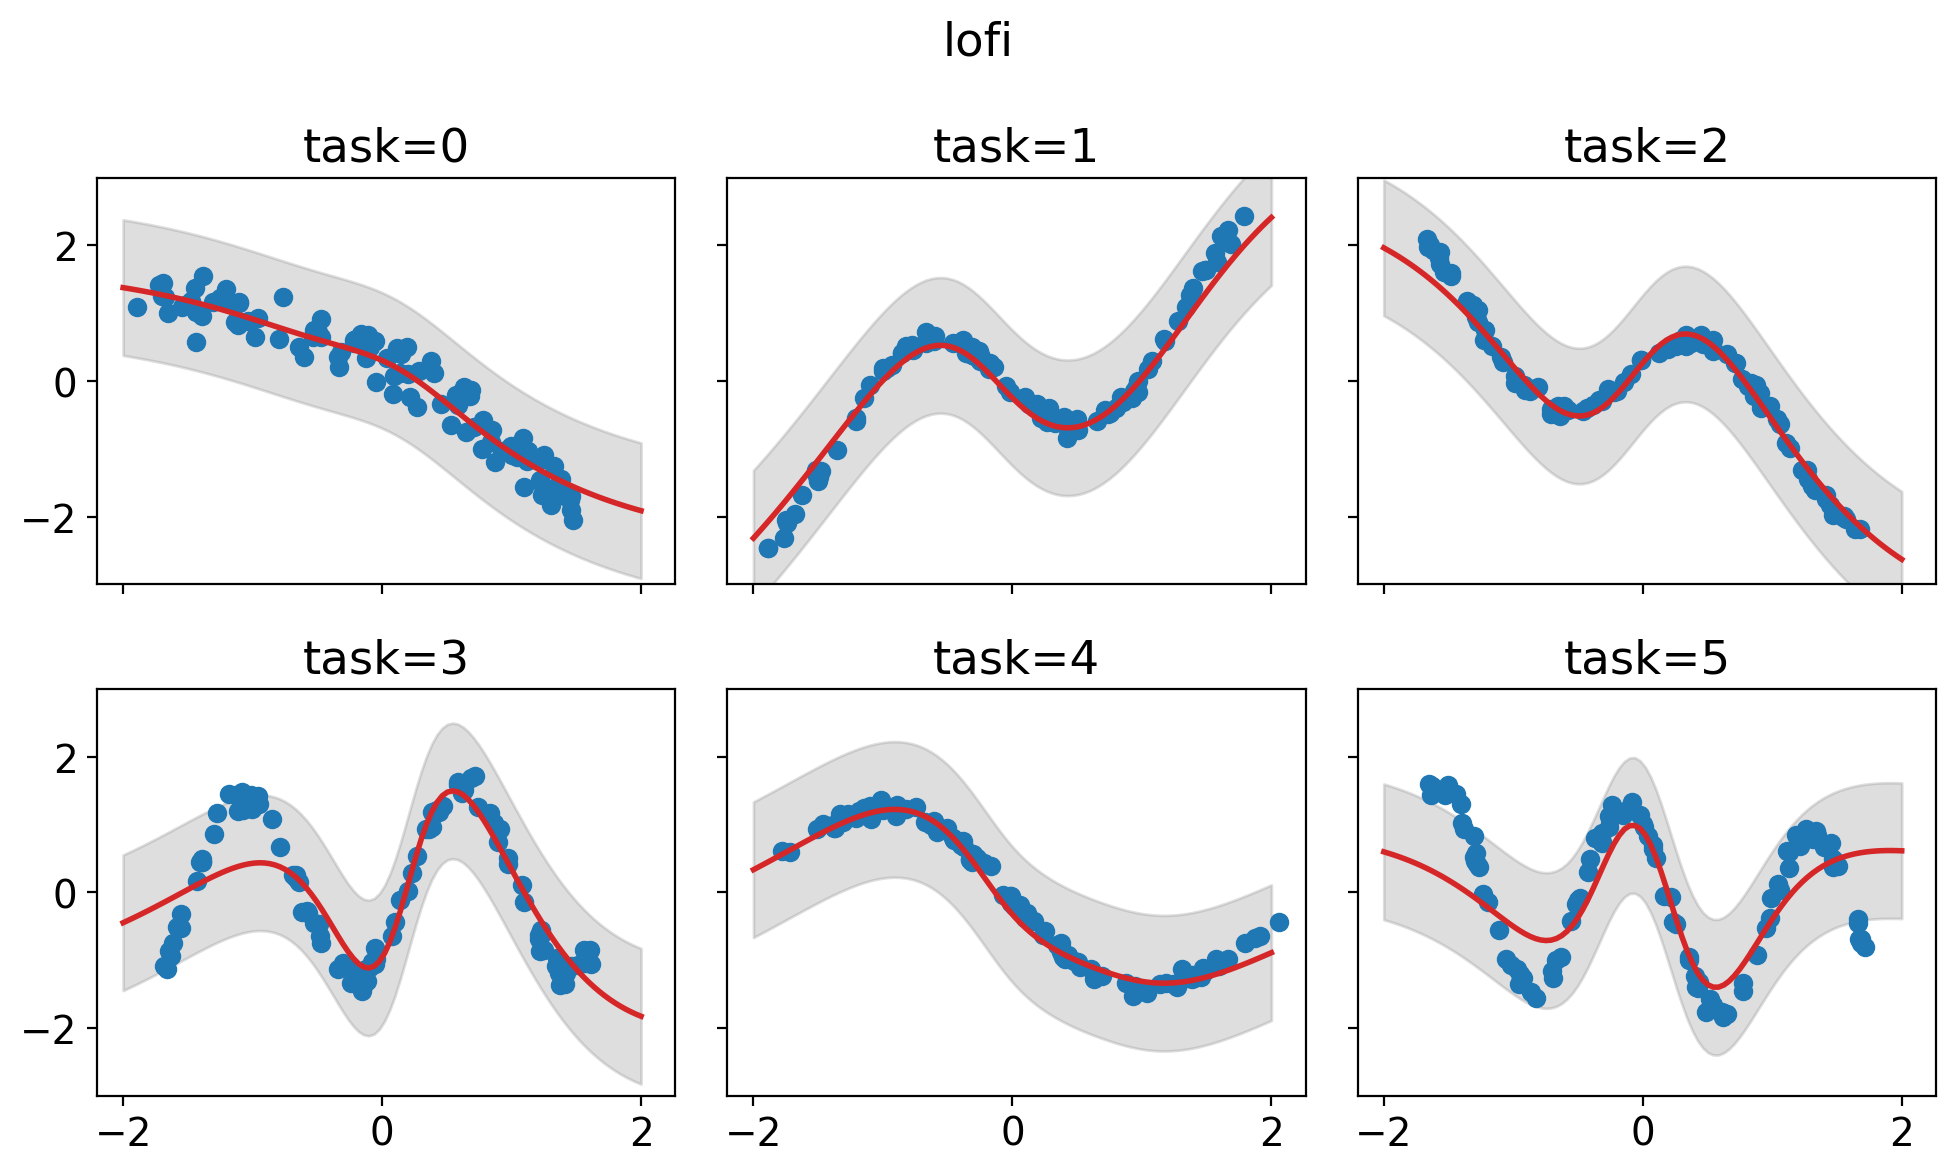

In [135]:
%%time
num_obs = 99
method = "lofi"

yhat_samples_all = yhat_samples_xmap[method][:, num_obs, ...]
    
fig, axs = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)

for task, ax in enumerate(axs.ravel()):
    xtest = X_test_tasks[task][:num_obs]
    # tasks, num train, samples, x-eval
    yhat_samples = yhat_samples_all[task]
    yhat_mean = yhat_samples.mean(axis=0)
    yhat_std = yhat_samples.std(axis=0)
    ylb = yhat_mean - 1 * std
    yub = yhat_mean + 1 * std
    
    ax.fill_between(xtest_ravel.ravel(), ylb, yub, color="tab:gray", linewidth=1, alpha=0.25)
        
    ax.plot(xtest_ravel, yhat_mean, c="tab:red", linewidth=2)
    ax.scatter(X_train_tasks[task, :num_obs], Y_train_tasks[task, :num_obs])
    ax.set_title(f"{task=}")
    ax.set_ylim(-3, 3)
plt.suptitle(method)
plt.tight_layout()

CPU times: user 2min 41s, sys: 16.9 s, total: 2min 58s
Wall time: 2min 13s


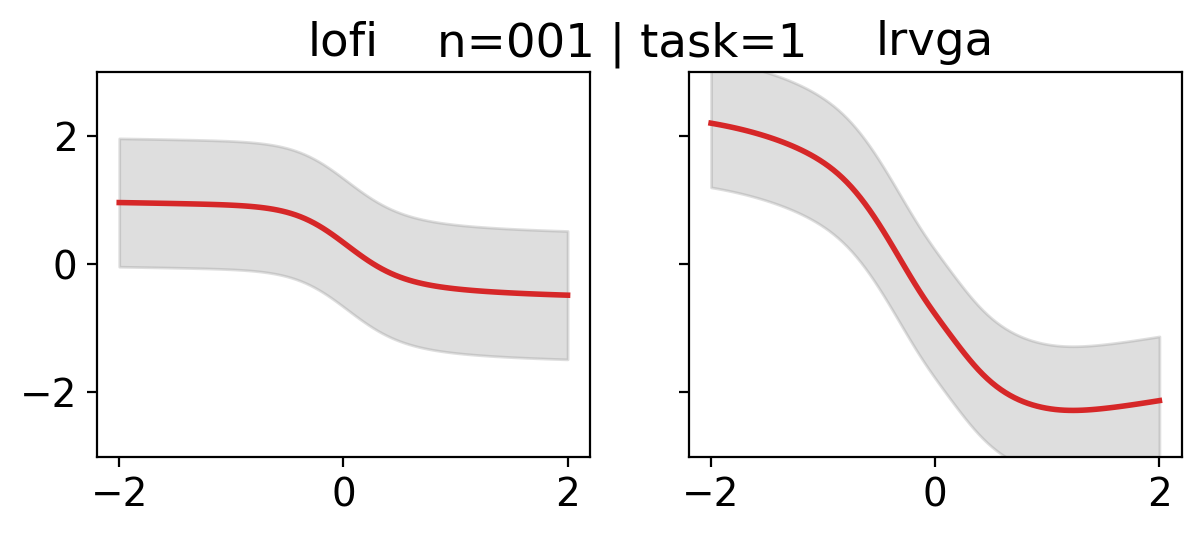

In [137]:
%%time
fig, axs = plt.subplots(1, 2, figsize=(7, 2.5), sharex=True, sharey=True)

labels = ["lofi", "lrvga"]

def update(ix):
    
    num_obs = ix % n_train
    task = ix // n_train
    
    xtest = X_test_tasks[task][:num_obs]
    
    for ax, label in zip(axs, labels):
        ax.cla()
        
        yhat_xmap = yhat_samples_xmap[label]
        yhat_samples = yhat_xmap[task, num_obs, ...]
        
        yhat_mean = yhat_samples.mean(axis=0)
        yhat_std = yhat_samples.std(axis=0)
        
        ylb = yhat_mean - 1 * std
        yub = yhat_mean + 1 * std
    
        ax.fill_between(xtest_ravel.ravel(), ylb, yub, color="tab:gray", linewidth=1, alpha=0.25)

        ax.plot(xtest_ravel, yhat_mean, c="tab:red", linewidth=2)
        ax.scatter(X_train_tasks[task, :num_obs], Y_train_tasks[task, :num_obs])
        ax.set_ylim(-3, 3)
        ax.set_title(label)

    plt.suptitle(f"n={num_obs+1:03} | task={task+1}")
    
frames = np.arange(n_dist * n_train)
ani = FuncAnimation(fig, update, frames=frames)
ani.save("./figures/posterior-predictive-comparison-bounds.mp4", dpi=100, bitrate=-1, fps=10)